In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from transformers import BertModel, BertTokenizer
import torch

In [2]:
# Read the dataset
df = pd.read_csv('Dataset/URLdatasetX2.csv')

In [3]:
# Encode categorical data
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

In [4]:
# BERT model setup
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def extract_features(text):
    input_ids = torch.tensor([tokenizer.encode(text, max_length=512, truncation=True, add_special_tokens=True)])
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    return torch.stack(features)

In [6]:
# Extract features from URLs
features = []
for i in range(len(df)):
    features.append(extract_features(df.iloc[i]["url"]))
features = torch.cat(features).numpy()
features_reshaped = features.reshape((len(df), -1))

In [7]:
# Concatenate features with target variable
dataset = np.hstack((features_reshaped, df['type_encoded'].values.reshape((-1, 1))))

In [8]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset[:, :-1], dataset[:, -1], test_size=0.2, random_state=42)

In [9]:
# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [10]:
# Train models
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_res, y_train_res)

gbc = GradientBoostingClassifier(max_depth=4, learning_rate=0.1)
gbc.fit(X_train_res, y_train_res)

svm = SVC(kernel='linear', C=1)
svm.fit(X_train_res, y_train_res)

SVC(C=1, kernel='linear')

Random Forest Accuracy: 0.9151356080489939


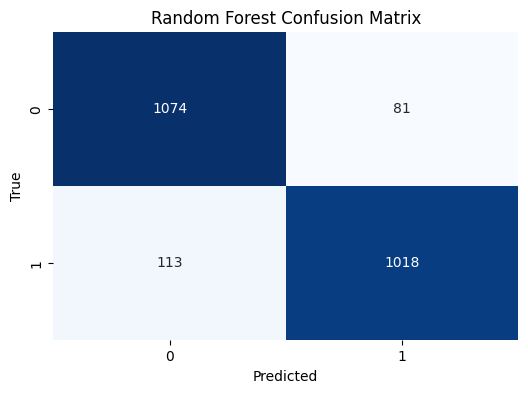

Gradient Boosting Accuracy: 0.9190726159230096


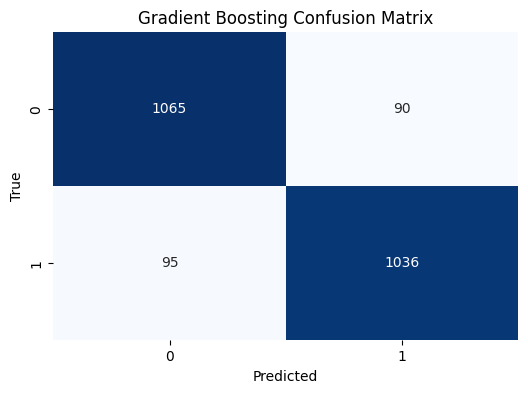

SVM Accuracy: 0.9304461942257218


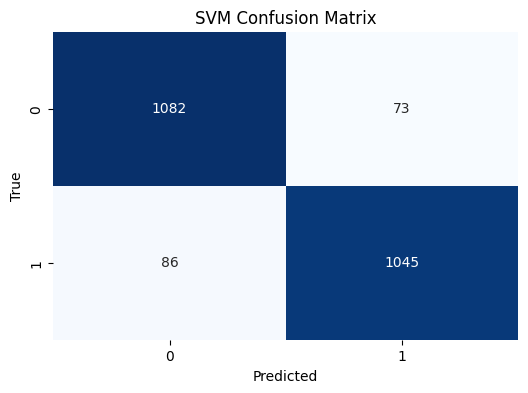

In [11]:
# Evaluate individual models
models = {'Random Forest': rf, 'Gradient Boosting': gbc, 'SVM': svm}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [12]:
# Ensemble using VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('Random Forest', rf),
    ('Gradient Boosting', gbc),
    ('SVM', svm)
], voting='hard')  # 'hard' for majority voting

ensemble.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('Random Forest', RandomForestClassifier()),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(max_depth=4)),
                             ('SVM', SVC(C=1, kernel='linear'))])

In [13]:
# Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {acc_ensemble}")

Ensemble Accuracy: 0.9295713035870516


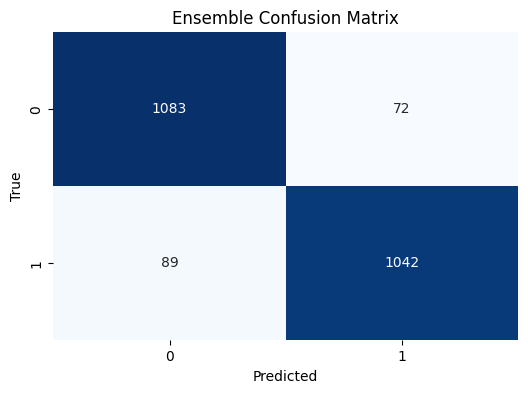

In [14]:
# Plot confusion matrix for ensemble
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()